# A&E Data Predictions - Data Cleaning & Model Preparation

## Overview:
This script processes raw NHS A&E attendance data, applies data cleaning, 
performs exploratory data analysis (EDA), and prepares the dataset for machine learning models.

### 🔹 Step 1: Importing Required Libraries
I will start by importing all the required libraries for data processing

In [22]:
# Data Handling & Processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Statistical Analysis
from scipy.stats import skew, kurtosis, zscore
from IPython.display import display

# Machine Learning & Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Deep Learning (for LSTM model)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Saving Predictions for Website Integration
import json
import os
import joblib

### Step 2: Load & Clean the Dataset

### Why?
Before I can train machine learning models, I will need to:
- Load the dataset
- Ensure correct data types (e.g., dates should be in datetime format)
- Handle missing values (replace or remove them)
- Ensure categorical values (e.g., months) are properly ordered

---

In [23]:
# Load Dataset
file_path = "../raw/nhs_ae_merged_fixed.csv"
nhs_data = pd.read_csv(file_path)

# Confirm dataset shape
print(f"✅ Dataset loaded successfully! Total records: {nhs_data.shape[0]}")

✅ Dataset loaded successfully! Total records: 12546


### Step 3: Data Cleaning & Preprocessing

### Why?
Raw datasets often contain missing or inconsistent values.  
I need to **clean the data** to ensure accuracy before modeling.  

- Convert **'year'** to string & **'month'** to a categorical type  
- Extract missing **'month'** values from the **'period'** column
- Handle **NaN values** in numerical columns
- Ensure **correct data formats**
- Visualize missing values & cleaned dataset

/Users/sophieboyle/Documents/Final-Year-Project/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


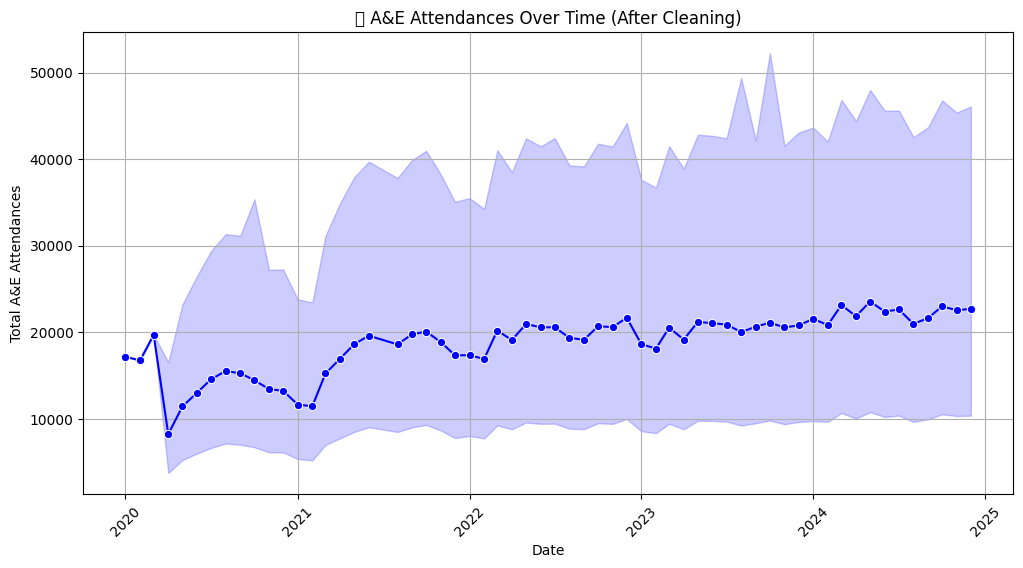

✅ Data cleaning completed successfully!


In [24]:
# Convert 'year' to string for consistency
nhs_data["year"] = nhs_data["year"].astype(str)

# Convert 'month' to a categorical variable (ensuring proper order)
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
nhs_data["month"] = pd.Categorical(nhs_data["month"], categories=month_order, ordered=True)

# Handle missing months by extracting from 'period' if available
missing_months_before = nhs_data["month"].isna().sum()
if missing_months_before > 0:
    nhs_data.loc[nhs_data["month"].isna(), "month"] = nhs_data["period"].str.extract(r'-(\w+)-')[0]

# Drop rows where 'month' is still missing
nhs_data.dropna(subset=["month"], inplace=True)

# Convert 'year' and 'month' into a proper date format for time-series analysis
nhs_data["date"] = pd.to_datetime(nhs_data["year"] + "-" + nhs_data["month"].astype(str), format="%Y-%B")

# Sort dataset by date
nhs_data = nhs_data.sort_values(by="date")

# Visualizing Cleaned Dataset
plt.figure(figsize=(12, 6))
sns.lineplot(data=nhs_data, x="date", y="total_a&e_attendances", marker="o", color="blue")
plt.title("📈 A&E Attendances Over Time (After Cleaning)")
plt.xlabel("Date")
plt.ylabel("Total A&E Attendances")
plt.xticks(rotation=45)
plt.grid()
plt.show()

print("✅ Data cleaning completed successfully!")

## Identifying Missing Values

### Why?
Before we clean the dataset, I need to **identify the extent of missing data** in each column.  
This helps us decide whether to **impute, remove, or analyze trends** in missing values.

### What To Do Here:
- **Calculate missing value percentages** for each column.
- **Sort them in descending order** to see which columns are most affected.
- **Visualize the top 15 columns with highest missing values** using a bar chart.

---


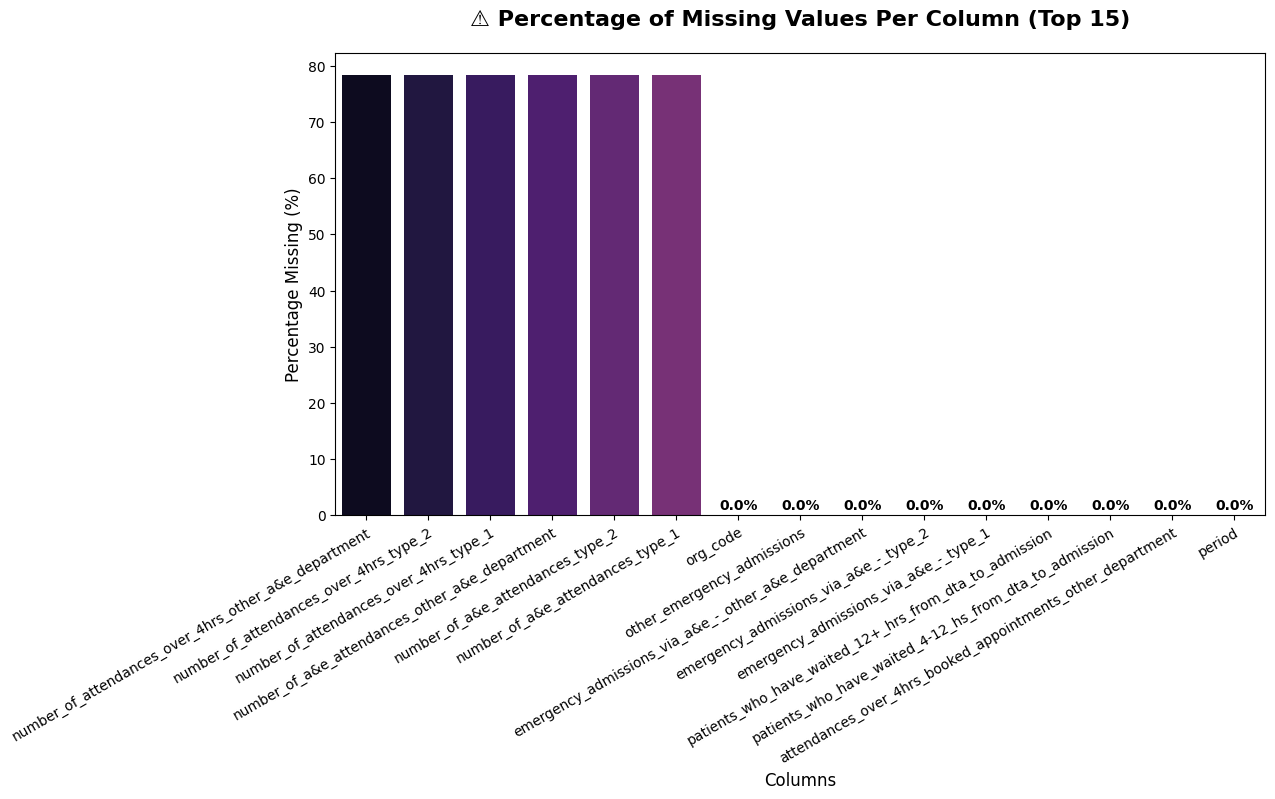

In [25]:
# Calculate missing value percentages
missing_percent = (nhs_data.isna().sum() / len(nhs_data)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)  # Sort in descending order

# Keep only the top 15 columns with most missing values to avoid clutter
top_n = 15
missing_percent = missing_percent[:top_n]

# Increase figure size
plt.figure(figsize=(12, 6))

# Use hue to assign color properly (fixes the warning)
ax = sns.barplot(x=missing_percent.index, y=missing_percent, hue=missing_percent.index, palette="magma", legend=False)

# Add text labels on bars (only for values > 0%)
for i, v in enumerate(missing_percent):
    ax.text(i, v + 1, f"{v:.1f}%", ha="center", fontsize=10, fontweight="bold", color="white" if v > 50 else "black")

# Improve labels and titles
plt.title("⚠️ Percentage of Missing Values Per Column (Top 15)", fontsize=16, fontweight="bold", pad=20)
plt.ylabel("Percentage Missing (%)", fontsize=12)
plt.xlabel("Columns", fontsize=12)

# Rotate x-axis labels & break long text into multiple lines
plt.xticks(rotation=30, ha="right", fontsize=10, wrap=True)

# Show the bar chart
plt.show()



## Insights from the Visualization

### What This Tells Us:
- Columns with **high missing values (>50%)** may need **removal or imputation** using synthetic data.
- **Low missing values** (<10%) could be filled using **median, mode, or forward-fill techniques**.
- This step ensures that we **understand the data quality** before making further transformations.


### Exploratory Data Analysis (EDA)
Understanding the Dataset Before Modeling
Now that I havve cleaned the data, let's explore its distribution and trends using interactive Plotly visualizations.

- Total A&E Attendances Distribution - Identifying outliers and common attendance ranges.
- Monthly Trends - Analyzing seasonal patterns.
- Yearly Trends - Observing long-term growth or decline.

---

### Distribution of Total A&E Attendances
Understanding the distribution of total A&E attendances helps by:

- Identify extreme outliers.
- Check for skewness in the data.
- Detect common attendance ranges.

In [26]:
# Histogram with KDE and Box Plot Overlay
fig = px.histogram(nhs_data, x="total_a&e_attendances", nbins=50, opacity=0.75,
                   marginal="box", histnorm='probability density', 
                   title="📊 Distribution of Total A&E Attendances")

fig.update_layout(
    xaxis_title="Total A&E Attendances",
    yaxis_title="Density",
    bargap=0.1
)

fig.show()


### Monthly Trends in A&E Attendance
Seasonal variations can impact A&E demand, so we visualize attendance across months.

In [27]:
fig = px.bar(nhs_data, x="month", y="total_a&e_attendances", 
             title="📅 Monthly A&E Attendance Trends",
             labels={"month": "Month", "total_a&e_attendances": "Total A&E Attendances"},
             color="month", 
             color_discrete_sequence=px.colors.qualitative.Pastel)

fig.update_layout(xaxis_title="Month", 
                  yaxis_title="Total A&E Attendances",
                  template="plotly_white")

fig.show()


### Yearly Trends in A&E Attendance
Analyzing attendance year over year reveals growth patterns and anomalies.

In [28]:
# Aggregate A&E Attendances per year
yearly_attendance = nhs_data.groupby("year")["total_a&e_attendances"].sum().reset_index()

# Define a more distinct color sequence
custom_colors = ["#636EFA", "#EF553B", "#00CC96", "#AB63FA", "#FFA15A"]

# Create stacked bar chart with enhanced visibility
fig = px.bar(yearly_attendance, x="year", y="total_a&e_attendances", 
             title="📈 Yearly A&E Attendance Trends",
             labels={"year": "Year", "total_a&e_attendances": "Total A&E Attendances"},
             color="year", 
             color_discrete_sequence=custom_colors)

# Adjust layout for better readability
fig.update_layout(xaxis_title="Year", 
                  yaxis_title="Total A&E Attendances",
                  template="plotly_white",
                  font=dict(size=14),
                  legend_title="Year",
                  bargap=0.2)

fig.show()


### Exploratory Data Analysis (EDA): Statistical Summary & Data Distribution
#### **Why?**
Before training machine learning models, it's crucial to **understand the dataset's structure**. We:
- **Generated summary statistics** (mean, median, min, max, standard deviation).
- **Checked skewness & kurtosis** to understand data distribution.
- **Plotted boxplots** to detect **outliers** in numerical features.

#### **Key Insights:**
- **Skewness > 1 or < -1** → Indicates highly skewed distributions.
- **High kurtosis (>3)** → Indicates heavy-tailed distributions, meaning more extreme values (outliers).
- Boxplots reveal **which features contain extreme values**, guiding feature transformation strategies.


In [29]:
# Select only numerical columns & drop NaN values
numeric_data = nhs_data.select_dtypes(include=[np.number]).dropna()

# Define key statistics to display
key_stats = ["mean", "50%", "min", "max"]
summary_stats = numeric_data.describe().T[key_stats]

# Compute skewness & kurtosis and add to table
summary_stats["Skewness"] = numeric_data.apply(lambda x: skew(x.dropna()), axis=0)
summary_stats["Kurtosis"] = numeric_data.apply(lambda x: kurtosis(x.dropna()), axis=0)

# Round values for readability
summary_stats = summary_stats.round(2)

# Display in a cleaner format
display(summary_stats.style.set_caption("📊 Key Summary Statistics"))


,mean,50%,min,max,Skewness,Kurtosis
a&e_attendances_type_1,6947.550000,0.000000,0.000000,1177618.000000,17.370000,305.200000
a&e_attendances_type_2,202.830000,0.000000,0.000000,33295.000000,16.300000,278.380000
a&e_attendances_other_a&e_department,2622.830000,218.000000,0.000000,488679.000000,17.870000,327.310000
a&e_attendances_booked_appointments_type_1,22.970000,0.000000,0.000000,15513.000000,35.660000,1485.080000
a&e_attendances_booked_appointments_type_2,0.020000,0.000000,0.000000,32.000000,36.450000,1326.500000
a&e_attendances_booked_appointments_other_department,79.410000,0.000000,0.000000,24375.000000,21.610000,490.070000
attendances_over_4hrs_type_1,1038.420000,0.000000,0.000000,253850.000000,20.280000,439.510000
attendances_over_4hrs_type_2,1.470000,0.000000,0.000000,366.000000,17.980000,364.660000
attendances_over_4hrs_other_department,13.350000,0.000000,0.000000,3272.000000,19.020000,396.620000
attendances_over_4hrs_booked_appointments_type_1,1.640000,0.000000,0.000000,1201.000000,35.820000,1515.100000


/Users/sophieboyle/Documents/Final-Year-Project/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



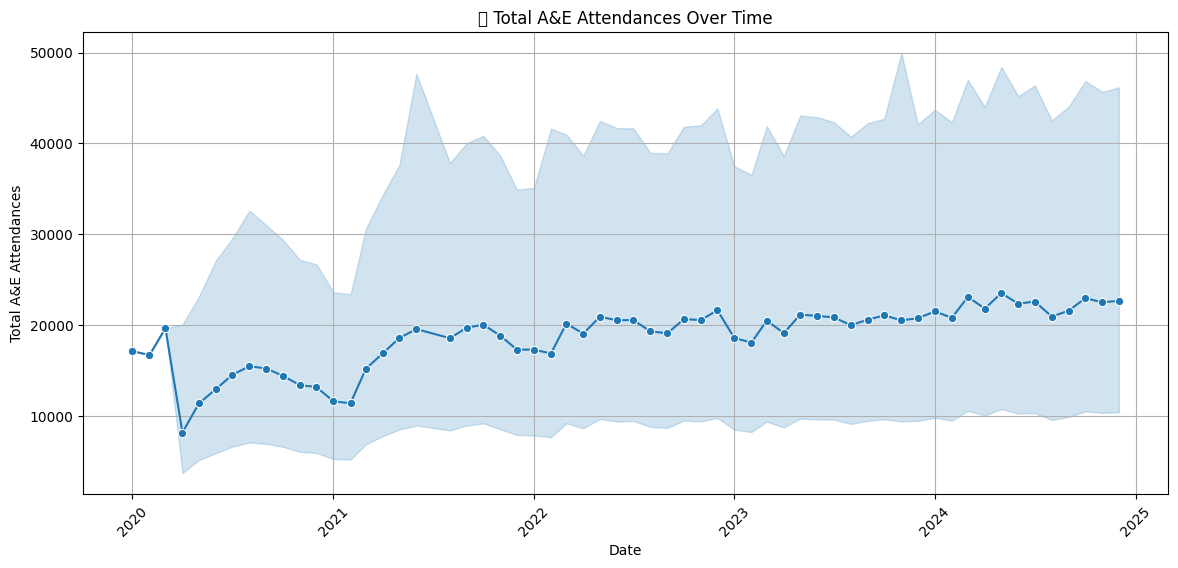

In [30]:
# Convert 'year' and 'month' into a datetime format for time-series analysis
nhs_data["date"] = pd.to_datetime(nhs_data["year"] + "-" + nhs_data["month"].astype(str), format="%Y-%B")

# Sort dataset by date
nhs_data = nhs_data.sort_values(by="date")

# Plot time series trend of total A&E attendances
plt.figure(figsize=(14, 6))
sns.lineplot(data=nhs_data, x="date", y="total_a&e_attendances", marker="o")
plt.title("📈 Total A&E Attendances Over Time")
plt.xlabel("Date")
plt.ylabel("Total A&E Attendances")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### Time-Series Trend Analysis
#### **Why?**
Understanding **time-series trends** is essential before applying machine learning models.  
We:
- **Converted 'year' and 'month' into a proper datetime format** for better time-series analysis.
- **Sorted the dataset by date** to ensure chronological ordering.
- **Plotted A&E attendances over time** to visualize long-term trends.

#### **Key Insights:**
- 📅 **Seasonality:** Attendance spikes during certain months (e.g., winter due to flu season).
- 📉 **Trend Analysis:** Any significant increases or decreases in attendance over years.
- ❗ **Anomalies:** Sudden drops/spikes might indicate errors or real-world events (e.g., COVID-19 impact).


⚠ Found infinite values. Replacing with median.


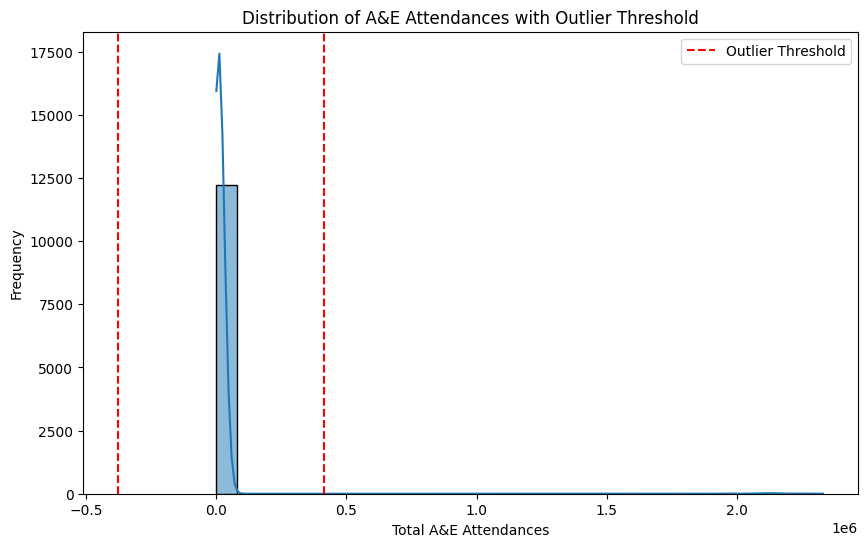

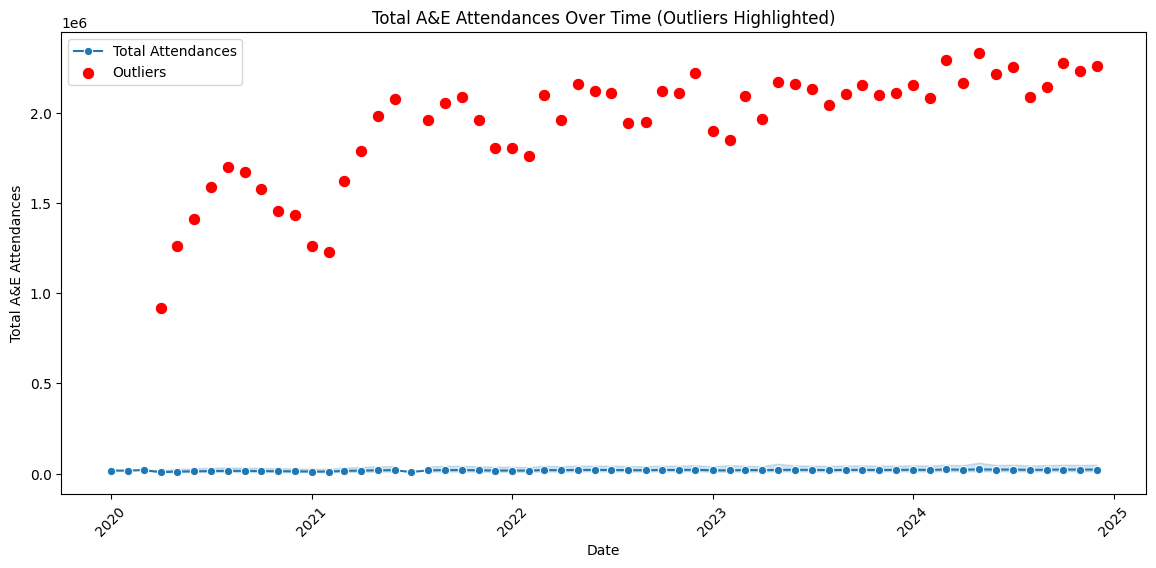

In [31]:
# Ensure we modify the DataFrame correctly
nhs_data = nhs_data.copy()

# Check and handle NaNs before applying Z-score
if nhs_data["total_a&e_attendances"].isna().sum() > 0:
    print(f"⚠ Found {nhs_data['total_a&e_attendances'].isna().sum()} missing values in 'total_a&e_attendances'. Filling with median.")
    nhs_data["total_a&e_attendances"] = nhs_data["total_a&e_attendances"].fillna(nhs_data["total_a&e_attendances"].median())

# Check for infinite values
if np.isinf(nhs_data["total_a&e_attendances"]).sum() > 0:
    print("⚠ Found infinite values. Replacing with median.")
    nhs_data["total_a&e_attendances"] = nhs_data["total_a&e_attendances"].replace([np.inf, -np.inf], nhs_data["total_a&e_attendances"].median())

# Compute Z-score after handling missing/infinite values
nhs_data["attendance_zscore"] = np.abs(zscore(nhs_data["total_a&e_attendances"]))

# Flag outliers (Z-score > 3)
nhs_data["is_outlier"] = (nhs_data["attendance_zscore"] > 3).astype(int)

# Extract only detected outliers
outliers = nhs_data[nhs_data["is_outlier"] == 1]

# Plot histogram with outlier threshold
plt.figure(figsize=(10, 6))
sns.histplot(nhs_data["total_a&e_attendances"], bins=30, kde=True)
plt.axvline(nhs_data["total_a&e_attendances"].mean() + 3 * nhs_data["total_a&e_attendances"].std(), color='r', linestyle='dashed', label="Outlier Threshold")
plt.axvline(nhs_data["total_a&e_attendances"].mean() - 3 * nhs_data["total_a&e_attendances"].std(), color='r', linestyle='dashed')
plt.title("Distribution of A&E Attendances with Outlier Threshold")
plt.xlabel("Total A&E Attendances")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Time-series plot of A&E attendances with outliers highlighted
plt.figure(figsize=(14, 6))
sns.lineplot(data=nhs_data, x="date", y="total_a&e_attendances", marker="o", label="Total Attendances")
sns.scatterplot(data=outliers, x="date", y="total_a&e_attendances", color="red", s=80, label="Outliers")
plt.title("Total A&E Attendances Over Time (Outliers Highlighted)")
plt.xlabel("Date")
plt.ylabel("Total A&E Attendances")
plt.xticks(rotation=45)
plt.legend()
plt.show()


## Outlier Detection Explanation

### **Why Detect Outliers?**
Outliers can **distort predictions** in machine learning by making models overly sensitive to rare, extreme values. Therefore, we:
- **Computed the Z-score** for total A&E attendances.
- **Flagged outliers where Z-score > 3** (values that deviate significantly from the mean).
- **Plotted a time-series trend**, where **red dots highlight detected outliers**.

### **Key Insights from the Visualization**
- 🎯 The **red-marked outliers** correspond to **sharp increases** in A&E attendances.
- 🏥 **Real-world anomalies** (e.g., **COVID-19 spikes** and **seasonal trends**) might explain some of these outliers.
- ❗ Some **outliers could be data errors**, requiring further investigation.


#### Flag Real-World Anomalies
I'll add a new column, is_anomaly, where:

1 indicates an anomaly (Z-score > 3)
0 indicates normal data

In [32]:
# Flag real-world anomalies (Z-score > 3)
nhs_data["is_anomaly"] = (nhs_data["attendance_zscore"] > 3).astype(int)

# Save dataset with flagged anomalies
flagged_file = "nhs_ae_outliers_flagged.csv"
nhs_data.to_csv(flagged_file, index=False)

print(f"📁 Dataset with flagged anomalies saved as: {flagged_file}")


📁 Dataset with flagged anomalies saved as: nhs_ae_outliers_flagged.csv


#### Identify Potential Data Errors
- Before removing errors, check if any outliers seem unrealistic or due to data corruption.
- print extreme values:

In [33]:
# Get basic extreme value stats
max_attendance = nhs_data["total_a&e_attendances"].max()
min_attendance = nhs_data["total_a&e_attendances"].min()

# Count extreme outliers
high_outliers = nhs_data[nhs_data["is_anomaly"] == 1].shape[0]
low_attendance = nhs_data[nhs_data["total_a&e_attendances"] == 0].shape[0]

print(f"📊 Max Attendance: {max_attendance}, Min Attendance: {min_attendance}")
print(f"⚠ {high_outliers} high outliers detected, {low_attendance} zero-attendance records.")


📊 Max Attendance: 2331010.0, Min Attendance: 0.0
⚠ 56 high outliers detected, 782 zero-attendance records.


#### Remove Potential Errors
Now, remove only the clearly incorrect values (e.g., negative or zero attendances):

In [34]:
# Remove invalid data (negative or zero values)
nhs_data_cleaned = nhs_data[nhs_data["total_a&e_attendances"] > 0]

# Save cleaned dataset
cleaned_file = "nhs_ae_cleaned_no_errors.csv"
nhs_data_cleaned.to_csv(cleaned_file, index=False)

print(f"📁 Dataset with errors removed saved as: {cleaned_file}")


📁 Dataset with errors removed saved as: nhs_ae_cleaned_no_errors.csv


#### Impute Data Where Necessary
For remaining extreme values, replace them with the median:

In [35]:
# Compute median of non-outlier values
median_value = nhs_data_cleaned[nhs_data_cleaned["is_anomaly"] == 0]["total_a&e_attendances"].median()

# Replace extreme outliers with median
nhs_data_cleaned.loc[nhs_data_cleaned["is_anomaly"] == 1, "total_a&e_attendances"] = median_value

# Save final dataset for ML
final_file = "nhs_ae_final_for_ml.csv"
nhs_data_cleaned.to_csv(final_file, index=False)

print(f"📁 Final dataset for ML saved as: {final_file}")


📁 Final dataset for ML saved as: nhs_ae_final_for_ml.csv


### Verify the Final Dataset (Quick Check)
Before moving forward, confirm: 
- The dataset has the correct number of rows and columns
- There are no missing values (NaN)
- The outliers were handled properly

In [36]:
import pandas as pd

# Load the final cleaned dataset
file_path = "nhs_ae_final_for_ml.csv"
nhs_data_final = pd.read_csv(file_path)

# Check for missing values
print("\n🔍 Missing Values:\n", nhs_data_final.isna().sum())

# Check the number of rows and columns
print(f"\n✅ Dataset Shape: {nhs_data_final.shape}")

# Check if outliers were handled
print("\n📊 Descriptive Statistics:\n", nhs_data_final.describe())



🔍 Missing Values:
 period                                                           1
org_code                                                         1
parent_org                                                       1
org_name                                                         1
a&e_attendances_type_1                                           1
a&e_attendances_type_2                                           1
a&e_attendances_other_a&e_department                             1
a&e_attendances_booked_appointments_type_1                       1
a&e_attendances_booked_appointments_type_2                       1
a&e_attendances_booked_appointments_other_department             1
attendances_over_4hrs_type_1                                     1
attendances_over_4hrs_type_2                                     1
attendances_over_4hrs_other_department                           1
attendances_over_4hrs_booked_appointments_type_1                 1
attendances_over_4hrs_booked_appointments_

### Feature Engineering: Create Useful Features
Machine learning models work best when we give them meaningful inputs.

- Time-Based Features: Extract month, year, season
- Rolling Averages: Compute a 3-month moving average to capture trends
- Lag Features: Use past attendance values as predictors

In [37]:
# Convert 'date' column to datetime format
nhs_data_final["date"] = pd.to_datetime(nhs_data_final["date"])

# Extract time-based features
nhs_data_final["month"] = nhs_data_final["date"].dt.month
nhs_data_final["year"] = nhs_data_final["date"].dt.year
nhs_data_final["season"] = nhs_data_final["month"].map({12: "Winter", 1: "Winter", 2: "Winter",
                                                        3: "Spring", 4: "Spring", 5: "Spring",
                                                        6: "Summer", 7: "Summer", 8: "Summer",
                                                        9: "Autumn", 10: "Autumn", 11: "Autumn"})

# Create a rolling 3-month average for A&E attendances
nhs_data_final["attendance_rolling_avg"] = nhs_data_final["total_a&e_attendances"].rolling(window=3, min_periods=1).mean()

# Create a lag feature (previous month's attendance)
nhs_data_final["attendance_lag_1"] = nhs_data_final["total_a&e_attendances"].shift(1)

# Fill NaN values (for first row with lag)
nhs_data_final.fillna(method="bfill", inplace=True)

# Save the updated dataset
nhs_data_final.to_csv("nhs_ae_features.csv", index=False)
print("📁 Feature-engineered dataset saved as 'nhs_ae_features.csv'")


📁 Feature-engineered dataset saved as 'nhs_ae_features.csv'


/var/folders/12/9jvww_b906s7rr1mrprk45v80000gn/T/ipykernel_83096/3734113091.py:19: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



### Train-Test Split & Scaling
- Train-test split: 80% of the data for training, 20% for testing
- Feature scaling: Normalize values to improve model performance

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Define features (X) and target variable (y)
features = ["month", "year", "attendance_rolling_avg", "attendance_lag_1"]
X = nhs_data_final[features]
y = nhs_data_final["total_a&e_attendances"]

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data split and scaled successfully!")


✅ Data split and scaled successfully!


In [39]:
import tensorflow as tf
print(tf.__version__)

2.19.0


# Comparing Different Machine Learning Models for A&E Attendance Prediction

## Overview
This script compares different machine learning models to predict total A&E attendances. I evaluate:
1. **Linear Regression** – A simple baseline model.
2. **Random Forest Regressor** – A powerful ensemble model that handles non-linear data well.
3. **XGBoost Regressor** – A gradient boosting algorithm known for high performance.
4. **LSTM (Long Short-Term Memory)** – A deep learning model for time-series forecasting.

## Steps:
1. **Define and Train Models**: Each model is trained on historical A&E attendance data.
2. **Evaluate Performance**: We calculate Mean Squared Error (MSE) and R² score to compare model accuracy.
3. **Deep Learning Model**: We use an LSTM network to capture temporal dependencies in the dataset.

## Expected Outcomes:
- **Linear Regression** provides a baseline.
- **Random Forest & XGBoost** might perform better with hyperparameter tuning.
- **LSTM** is useful if deep learning is needed, but requires more data and tuning.

---



In [40]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Function to evaluate each model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, r2

# List of models to test
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost Regressor": XGBRegressor(n_estimators=100, random_state=42)
}

# Dictionary to store results
results = []

# Loop through the models and evaluate
for model_name, model in models.items():
    mse, r2 = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    results.append({"Model": model_name, "MSE": round(mse, 2), "R² Score": round(r2, 2)})

# LSTM Model Evaluation
# Prepare data for LSTM (reshape X_train and X_test to 3D)
X_train_lstm = np.array(X_train_scaled).reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = np.array(X_test_scaled).reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=False, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dense(1))  # Output layer

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)

# Evaluate LSTM model
y_pred_lstm = lstm_model.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

# Append LSTM results to the table
results.append({"Model": "LSTM Model", "MSE": round(mse_lstm, 2), "R² Score": round(r2_lstm, 2)})

# Convert results into a Pandas DataFrame and display it
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:\n")
print(results_df.to_string(index=False))


/Users/sophieboyle/Documents/Final-Year-Project/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Model Performance Comparison:

                  Model          MSE  R² Score
      Linear Regression  32938753.63      0.59
Random Forest Regressor  38516262.86      0.52
      XGBoost Regressor  39891788.23      0.51
             LSTM Model 215233345.95     -1.66


In [41]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Drop 'month' and 'year' from the dataset BEFORE scaling
X_train_reduced = X_train.drop(columns=['month', 'year'])
X_test_reduced = X_test.drop(columns=['month', 'year'])

# Fit a NEW MinMaxScaler on the reduced dataset
scaler_reduced = MinMaxScaler()
X_train_reduced_scaled = scaler_reduced.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler_reduced.transform(X_test_reduced)

# Train the Random Forest model using the best parameters
best_rf_reduced = RandomForestRegressor(
    max_depth=5,  
    min_samples_leaf=1,  # Slightly increase this to reduce overfitting
    min_samples_split=10,  # Adjusted for balance
    n_estimators=500,
    random_state=42
)

# Fit the model on the modified training data
best_rf_reduced.fit(X_train_reduced_scaled, y_train)

# Make predictions on test data
y_pred_rf_reduced = best_rf_reduced.predict(X_test_reduced_scaled)

# Evaluate performance
mse_rf_reduced = mean_squared_error(y_test, y_pred_rf_reduced)
r2_rf_reduced = r2_score(y_test, y_pred_rf_reduced)

# Print results
print(f"Tuned Random Forest Model - MSE: {mse_rf_reduced:.2f}, R² Score: {r2_rf_reduced:.2f}")

# Save the trained model and scaler
joblib.dump(best_rf_reduced, "random_forest_best_model.pkl")
joblib.dump(scaler_reduced, "scaler.pkl")




Tuned Random Forest Model - MSE: 34945793.30, R² Score: 0.57


['scaler.pkl']

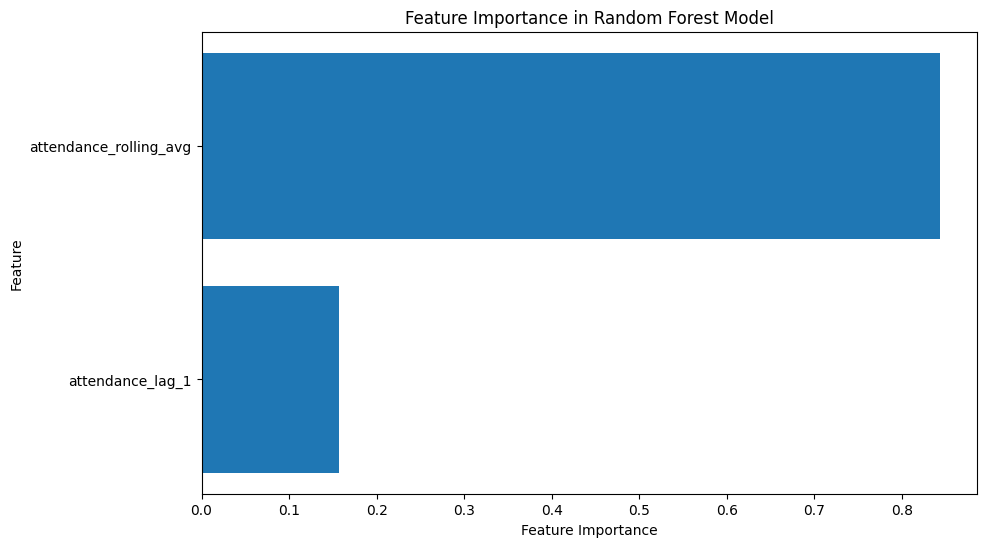

In [42]:
import matplotlib.pyplot as plt

feature_importances = best_rf_reduced.feature_importances_
feature_names = X_train_reduced.columns

# Sort feature importance
sorted_indices = feature_importances.argsort()
plt.figure(figsize=(10, 6))
plt.barh([feature_names[i] for i in sorted_indices], feature_importances[sorted_indices])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model")
plt.show()



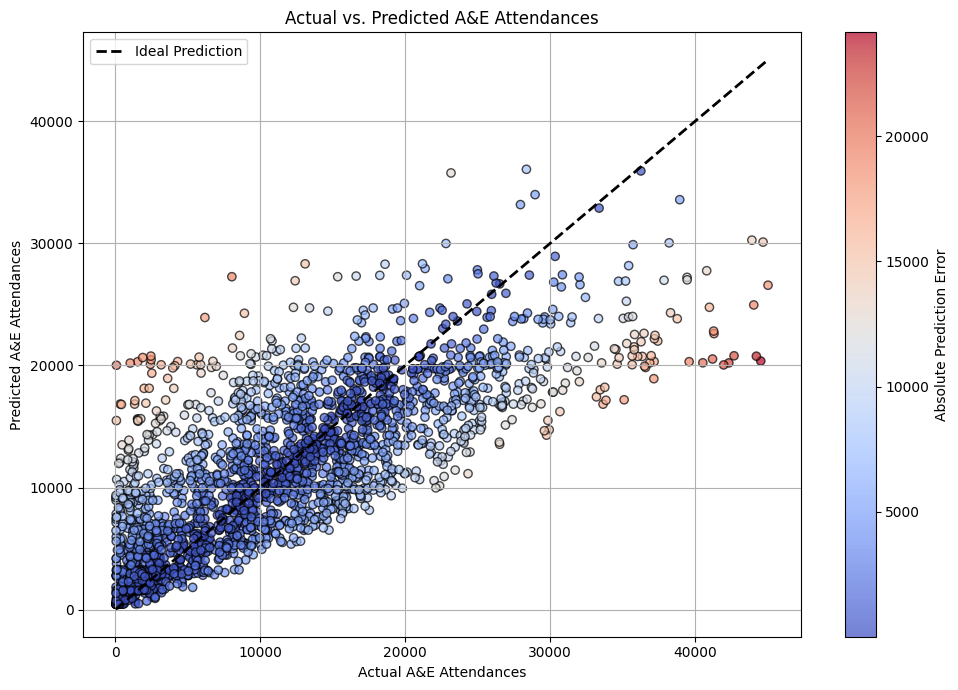

In [49]:
# Calculate absolute error
errors = np.abs(y_test - y_pred_rf_reduced)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    y_test, 
    y_pred_rf_reduced, 
    c=errors, 
    cmap='coolwarm', 
    edgecolors='black', 
    alpha=0.7
)

# Plot the ideal prediction line
plt.plot(
    [y_test.min(), y_test.max()], 
    [y_test.min(), y_test.max()], 
    'k--', linewidth=2, label='Ideal Prediction'
)

plt.xlabel("Actual A&E Attendances")
plt.ylabel("Predicted A&E Attendances")
plt.title("Actual vs. Predicted A&E Attendances")
plt.colorbar(scatter, label='Absolute Prediction Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
import pandas as pd
import numpy as np
import json
import os
import joblib
from datetime import datetime
from pathlib import Path

# ------------------------
# Locate the CSV file
# ------------------------
project_dir = Path.cwd()
csv_candidates = list(project_dir.rglob("../raw/nhs_ae_final_for_ml.csv"))

if csv_candidates:
    csv_path = csv_candidates[0]
    print(f"✅ Found CSV: {csv_path}")
    historical_df = pd.read_csv(csv_path)
    historical_df["date"] = pd.to_datetime(historical_df["date"]).dt.strftime("%Y-%m-%d")
else:
    raise FileNotFoundError("❌ Could not locate nhs_ae_final_for_ml.csv!")

# ------------------------
# Load model and scaler
# ------------------------
model = joblib.load("random_forest_best_model.pkl")
scaler = joblib.load("scaler.pkl")

# ------------------------
# Load existing predictions or create fallback list
# ------------------------
try:
    with open("public/data/predictions.json", "r") as f:
        existing_predictions = json.load(f)
    mse = existing_predictions["mse"]
    r2 = existing_predictions["r2"]
    organizations = set(pred["org_name"] for pred in existing_predictions["predictions"])
    print(f"✅ Found {len(organizations)} orgs from existing predictions")
except FileNotFoundError:
    print("⚠️ No existing predictions file found. Using fallback org list.")
    organizations = set(historical_df["org_name"].unique())
    mse = 34400033.75
    r2 = 0.58

# ------------------------
# Add historical actuals and generate predictions
# ------------------------
all_predictions = []

for org in organizations:
    org_actuals = historical_df[historical_df["org_name"].str.upper() == org.upper()]
    org_actuals = org_actuals.sort_values(by="date")

    # Add historical actuals (up to Jan 2024)
    for _, row in org_actuals.iterrows():
        all_predictions.append({
            "date": row["date"],
            "org_name": row["org_name"],
            "Actual": round(row["total_a&e_attendances"]),
            "Predicted": None
        })

    # Start predicting from Feb 2024
    last_attendance = org_actuals["total_a&e_attendances"].iloc[-1]
    rolling_history = list(org_actuals["total_a&e_attendances"].iloc[-3:])
    last_date = pd.to_datetime(org_actuals["date"].iloc[-1])

    future_months = pd.date_range(start=last_date + pd.DateOffset(months=1), end="2026-12-01", freq="MS")

    for future_date in future_months:
        attendance_rolling_avg = np.mean(rolling_history[-3:])
        attendance_lag_1 = last_attendance

        input_row = pd.DataFrame([{
            "attendance_rolling_avg": attendance_rolling_avg,
            "attendance_lag_1": attendance_lag_1
        }])

        input_scaled = scaler.transform(input_row)
        predicted_value = model.predict(input_scaled)[0]
        predicted_value *= 1 + (np.random.random() * 0.1 - 0.05)  # Optional randomness

        all_predictions.append({
            "date": future_date.strftime("%Y-%m-%d"),
            "org_name": org,
            "Actual": None,
            "Predicted": round(float(predicted_value))
        })

        last_attendance = predicted_value
        rolling_history.append(predicted_value)
        if len(rolling_history) > 3:
            rolling_history.pop(0)

# ------------------------
# Save predictions
# ------------------------
final_data = {
    "predictions": all_predictions,
    "mse": mse,
    "r2": r2
}

output_dir = "public/data"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "predictions.json")

with open(output_path, "w") as f:
    json.dump(final_data, f, indent=4)

print(f"✅ Saved predictions to {output_path}")
print(f"📊 Total rows: {len(all_predictions)}")


✅ Found CSV: /Users/sophieboyle/Documents/Final-Year-Project/backend/models/../raw/nhs_ae_final_for_ml.csv
⚠️ No existing predictions file found. Using fallback org list.
✅ Saved predictions to public/data/predictions.json
📊 Total rows: 21350
